# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score


from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [4]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [5]:
grab_numeric(X)

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500
...,...,...,...,...,...
886,2,27.0,0,0,13.0000
887,1,19.0,0,0,30.0000
888,3,NaN,1,2,23.4500
889,1,26.0,0,0,30.0000


In [6]:
# The FunctionTransformer will turn my function
# into a transformer.
GrabNumeric = FunctionTransformer(grab_numeric)

In [7]:
# Pipe!

pipe = Pipeline(steps=[
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

In [8]:
pipe.fit(X)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x7fbb18b381f0>)),
                ('ss', StandardScaler())])

In [9]:
pipe.transform(X)

array([[ 0.82737724, -0.53037664,  0.43279337, -0.47367361, -0.50244517],
       [-1.56610693,  0.57183099,  0.43279337, -0.47367361,  0.78684529],
       [ 0.82737724, -0.25482473, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [ 0.82737724,         nan,  0.43279337,  2.00893337, -0.17626324],
       [-1.56610693, -0.25482473, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.82737724,  0.15850313, -0.4745452 , -0.47367361, -0.49237783]])

That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [10]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical
subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Selector!!!!

[This](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector) will return a callable list of columns

In [12]:
# Selector!

test = selector(dtype_include=object)

test(X)

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [13]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [14]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy='most_frequent'))
])


In [64]:
dummy_model = dummy_model_pipe.fit(X_train, y_train)

In [65]:
dummy_model.score(X_train, y_train)

0.6212574850299402

In [66]:
dummy_model.score(X_test, y_test)

0.600896860986547

In [15]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42))
])

## Bringing in Our Modeling Class from before

In [16]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [17]:
# Create Dummy/Baseline

dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `dummy_model` Model'}>

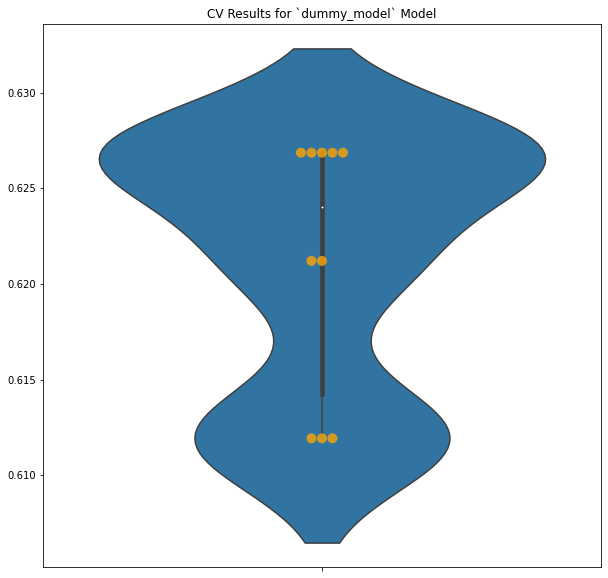

In [68]:
# Use the class with out dummy pipe

fig, ax = plt.subplots(figsize=(10,10))

dummy_pipe.plot_cv(ax)

In [19]:
# Create FSM (First Simple Model)
logreg_pipe = ModelWithCV(logreg_model_pipe, 'logreg_model', X_train, y_train)

In [20]:
logreg_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.80249 ± 0.06362 accuracy
        


<AxesSubplot:title={'center':'CV Results for `logreg_model` Model'}>

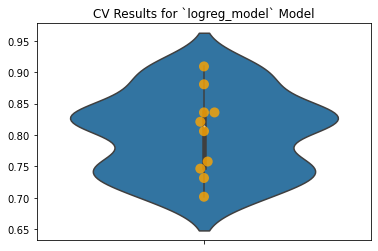

In [21]:
fig, ax = plt.subplots()

logreg_pipe.plot_cv(ax)

In [22]:
# Use the class with out logreg pipe


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [23]:
# rfc!

rfc_model_pipe = Pipeline([
    ('ct', CT),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [24]:
rfc_pipe = ModelWithCV(rfc_model_pipe, 'rfc_model', X_train, y_train)

In [25]:
rfc_pipe.print_cv_summary()

CV Results for `rfc_model` model:
            0.82802 ± 0.05856 accuracy
        


<AxesSubplot:title={'center':'CV Results for `rfc_model` Model'}>

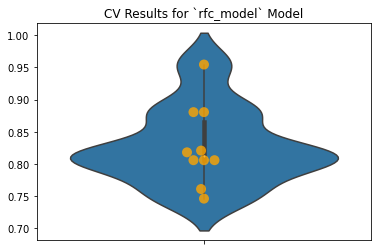

In [26]:
fig, ax = plt.subplots()

rfc_pipe.plot_cv(ax)

### Gradient Booster

In [27]:
# gbc!
gbc = GradientBoostingClassifier(random_state=42)


gbc_model_pipe = Pipeline([
    ('ct', CT),
    ('gbc', gbc)
])

In [28]:
gbc_pipe = ModelWithCV(gbc_model_pipe, 'gbc_model', X_train, y_train)

In [29]:
gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.82641 ± 0.05989 accuracy
        


<AxesSubplot:title={'center':'CV Results for `gbc_model` Model'}>

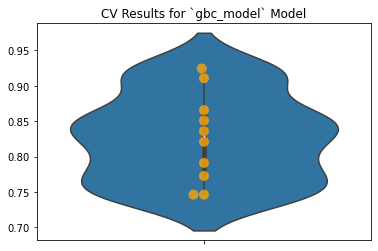

In [30]:
fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax)

## Tuning and Cross-Validating

In [31]:
# GridSearch?

rfc_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbafb30a8e0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                           

In [32]:
subpipe_num

Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                ('ss', StandardScaler())])

In [33]:
# Mean test score for each of six models

params = {}

params['ct__subpipe_num__num_impute__strategy'] = ['mean', 'median']
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1,5,10]

In [34]:
params

{'ct__subpipe_num__num_impute__strategy': ['mean', 'median'],
 'rfc__criterion': ['gini', 'entropy'],
 'rfc__min_samples_leaf': [1, 5, 10]}

In [35]:
gs = GridSearchCV(rfc_model_pipe, params, cv=10, verbose=1)

In [36]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   13.1s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbafb30a8e0>),
                                                                        ('subpipe_cat',
                                                                         Pipelin

In [37]:
gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'median',
 'rfc__criterion': 'entropy',
 'rfc__min_samples_leaf': 1}

In [38]:
gs.best_score_

0.8294436906377204

In [39]:
gs.cv_results_['mean_test_score'].mean()

0.6896615407809437

In [40]:
gs.score(X_train, y_train)

0.9985029940119761

In [41]:
gs.score(X_test, y_test)

0.8340807174887892

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [42]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [43]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [44]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [45]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [46]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [47]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [48]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [49]:
# imbpipe!

imb_pipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm',SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [50]:
imb_pipe.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbafb30a8e0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                           

In [51]:
imb_pipe.score(X_train_clean, y_train_clean)

0.9794776119402985

### Gridsearching

In [52]:
# Seriously? Again?

parameters = {
    'rfc__criterion':['gini', 'entropy'],
    'rfc__min_samples_leaf': [1,5,10],
    'sm__k_neighbors': [3,5,7]
}

gs = GridSearchCV(imb_pipe, parameters, cv=10, verbose=2)

In [53]:
gs.fit(X_train_clean, y_train_clean)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighb

[CV]  rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=7 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=5, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=10, sm__k_neighbors=3 
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=10, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=10, sm__k_neighbors=3 
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=10, sm__k_neighbors=3, total=   0.1s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=10, sm__k_neighbors=3 
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=10, sm__k_nei

[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=7 
[CV]  rfc__criterion=entropy, rfc_

[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5, total=   0.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=10, sm__k_neighbors=5 
[CV]  rfc__criterion=e

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   17.2s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbafb30a8e0>),
                                                                        ('subpipe_cat',
                                                                         Pipelin

In [54]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 10, 'sm__k_neighbors': 3}

In [55]:
gs.best_score_

0.7052760307477288

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [56]:
final_model = ImPipeline(steps=[
    ('ct', CT),
    ('sm',SMOTE(k_neighbors=3, random_state=42)),
    ('rfc', RandomForestClassifier(min_samples_leaf=10, random_state=42, criterion='gini'))
])

In [57]:
final_model.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbafb30a8e0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                           

In [58]:
final_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbafb30a8e0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
      

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


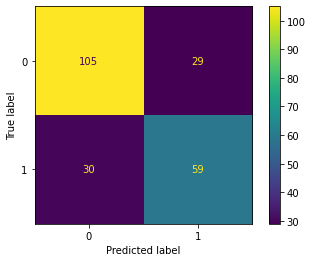

In [59]:
plot_confusion_matrix(final_model, X_test, y_test);

In [60]:
y_hat = final_model.predict(X_test)

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [61]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.74. 

Our final model's recall on the test set is 0.66 

Our final model's precision on the test set is 0.67 

Our final model's f1-score on the test is 0.67.



## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [62]:
exos = sns.load_dataset('planets')

In [63]:
### Your work here






